<a href="https://colab.research.google.com/github/Hangyeol82/AI_lab/blob/main/%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 과제



In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [15]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


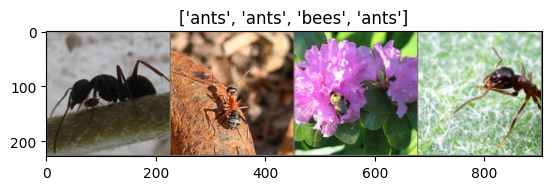

In [16]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [18]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [4]:
!unzip "/content/hymenoptera_data (1).zip" -d "/content/"

Archive:  /content/hymenoptera_data (1).zip
   creating: /content/hymenoptera_data/
   creating: /content/hymenoptera_data/train/
   creating: /content/hymenoptera_data/train/ants/
  inflating: /content/hymenoptera_data/train/ants/0013035.jpg  
  inflating: /content/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: /content/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: /content/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: /content/hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: /content/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: /content/hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: /content/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: /content/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: /content/hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: /content/hymenoptera_data/train/ants/13602

In [10]:
model_ft = models.efficientnet_b3(weights='IMAGENET1K_V1')
num_ftrs = model_ft.classifier[1].in_features # Access the in_features of the linear layer within the classifier
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.classifier[1] = nn.Linear(num_ftrs, 2)


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6110 Acc: 0.7008
val Loss: 0.5097 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.4805 Acc: 0.7910
val Loss: 0.3779 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4041 Acc: 0.8484
val Loss: 0.3070 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.3610 Acc: 0.8320
val Loss: 0.2756 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.3663 Acc: 0.8320
val Loss: 0.2508 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.3167 Acc: 0.8689
val Loss: 0.2665 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.3626 Acc: 0.8402
val Loss: 0.2719 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3702 Acc: 0.8238
val Loss: 0.2597 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3185 Acc: 0.8770
val Loss: 0.2482 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2828 Acc: 0.8770
val Loss: 0.2453 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3492 Acc: 0.8525
val Loss: 0.2525 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.3873 Acc: 0.7992
val Loss: 0.2506 Acc: 0.9216

Ep

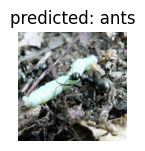

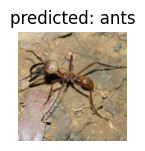

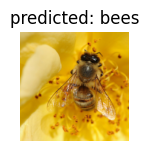

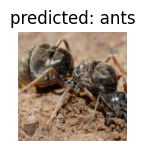

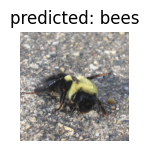

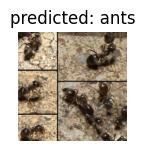

In [20]:
visualize_model(model_ft)


In [23]:
model_conv = torchvision.models.efficientnet_b3(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[1].in_features # Access the in_features of the linear layer within the classifier
model_conv.classifier[1] = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier[1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [24]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.6027 Acc: 0.7049
val Loss: 0.5143 Acc: 0.8170

Epoch 1/24
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4708 Acc: 0.8033
val Loss: 0.3912 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4438 Acc: 0.8197
val Loss: 0.3626 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4051 Acc: 0.8320
val Loss: 0.3250 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.4014 Acc: 0.8197
val Loss: 0.3174 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.3842 Acc: 0.8361
val Loss: 0.2808 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4099 Acc: 0.7951
val Loss: 0.3225 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.3381 Acc: 0.8566
val Loss: 0.3132 Acc: 0.8693

Epoch 8/24
----------
train Loss: 0.3519 Acc: 0.8648
val Loss: 0.2554 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.4021 Acc: 0.8197
val Loss: 0.3342 Acc: 0.8627

Epoch 10/24
----------
train Loss: 0.4346 Acc: 0.7746
val Loss: 0.3491 Acc: 0.8693

Epoch 11/24
----------
train Loss: 0.3902 Acc: 0.8320
val Loss: 0.2743 Acc: 0.8954

Epoch 12/24
----------
train Loss: 0.4158 Acc: 0.8197
val Loss: 0.3094 Acc: 0.8889

Epoch 13/24
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3836 Acc: 0.8115
val Loss: 0.2852 Acc: 0.8889

Epoch 15/24
----------
train Loss: 0.3759 Acc: 0.8033
val Loss: 0.3092 Acc: 0.8889

Epoch 16/24
----------
train Loss: 0.4062 Acc: 0.8566


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.2895 Acc: 0.8824

Epoch 17/24
----------
train Loss: 0.4062 Acc: 0.8361
val Loss: 0.2904 Acc: 0.8758

Epoch 18/24
----------
train Loss: 0.3765 Acc: 0.8320
val Loss: 0.2551 Acc: 0.9216

Epoch 19/24
----------
train Loss: 0.3217 Acc: 0.8852
val Loss: 0.2746 Acc: 0.9020

Epoch 20/24
----------
train Loss: 0.3577 Acc: 0.8197
val Loss: 0.3052 Acc: 0.8758

Epoch 21/24
----------
train Loss: 0.3763 Acc: 0.8156
val Loss: 0.2882 Acc: 0.8954

Epoch 22/24
----------
train Loss: 0.3642 Acc: 0.8566
val Loss: 0.3047 Acc: 0.8693

Epoch 23/24
----------
train Loss: 0.3428 Acc: 0.8566
val Loss: 0.2872 Acc: 0.8758

Epoch 24/24
----------
train Loss: 0.3718 Acc: 0.8074
val Loss: 0.2710 Acc: 0.9085

Training complete in 1m 35s
Best val Acc: 0.928105


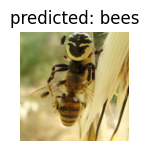

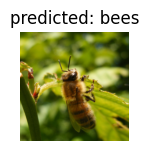

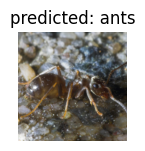

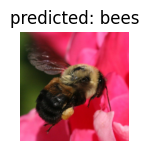

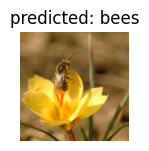

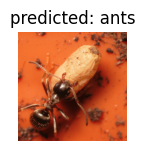

In [25]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [26]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

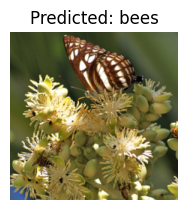

In [28]:
visualize_model_predictions(
    model_conv,
    img_path='/content/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()